# 🧠 Personality Classification - Reddit Large Dataset

## 📋 Mục tiêu
Notebook này cải tiến phương pháp gốc bằng cách sử dụng **dataset lớn hơn** (Reddit Posts) thay vì MBTI dataset nhỏ.

## 🔍 Vấn đề với dataset nhỏ (MBTI - 8,675 users)

1. **Sample size nhỏ**: Chỉ có ~8,675 users, không đủ để model học patterns phức tạp
2. **Overfitting risk**: Dataset nhỏ dễ dẫn đến overfitting
3. **Limited diversity**: Ít đa dạng về writing styles và topics

## 🛠️ Giải pháp

Sử dụng **Reddit Posts dataset** với ~13 triệu posts từ nhiều users hơn:
- Nhiều samples hơn → Model học tốt hơn
- Đa dạng hơn về nội dung và writing styles
- Kết hợp với **Group-based split** để tránh data leakage

## 📊 Kỳ vọng
- Accuracy có thể **tăng** do có nhiều data hơn để học
- Model generalizes tốt hơn trên unseen users
- Kết quả ổn định hơn (lower variance)


In [18]:
# ============================================
# 🔧 INSTALL DEPENDENCIES
# ============================================
%pip install -q imbalanced-learn xgboost wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
# ============================================
# 📚 IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
from tqdm.auto import tqdm
import gc
warnings.filterwarnings('ignore')

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# XGBoost
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries loaded!")

✅ All libraries loaded!


---
## 1. 📥 Load Reddit Dataset


In [20]:
# ============================================
# 📥 LOAD REDDIT DATASET
# ============================================
# Dataset có ~13 triệu rows, ta sẽ sample để có thể xử lý

# Nếu chạy trên Colab, upload file hoặc mount Google Drive
# Nếu chạy local, đảm bảo file reddit_post.csv ở cùng thư mục

# Đọc file với chunks để xử lý file lớn
print("Loading Reddit dataset...")
print("⚠️ File lớn (~13M rows), đang đọc...")

# Đọc toàn bộ file (có thể mất vài phút)
# Nếu memory không đủ, giảm số rows
try:
    # Thử đọc từ URL (nếu có)
    reddit_url = 'https://raw.githubusercontent.com/ducnt3/IT4868E/refs/heads/master/reddit_post.csv'
    df_reddit = pd.read_csv(reddit_url, nrows=500000)  # Giới hạn 500K rows để test
except:
    # Đọc từ file local
    df_reddit = pd.read_csv('reddit_post.csv', nrows=500000)

print(f"\n✅ Reddit dataset loaded: {len(df_reddit):,} posts")
print(f"   Unique authors: {df_reddit['author'].nunique():,}")
print(f"   Unique MBTI types: {df_reddit['mbti'].nunique()}")
df_reddit.head()

Loading Reddit dataset...
⚠️ File lớn (~13M rows), đang đọc...

✅ Reddit dataset loaded: 500,000 posts
   Unique authors: 9,918
   Unique MBTI types: 16


,author,body,mbti
0,LadyBanterbury,lol thats why i left,INFP
1,Finarin,i was just about to post i try telling people ...,INTP
2,xanplease,my first thought was pepsi or something probab...,INFP
3,HeirToGallifrey,not if the formula is something like every tim...,ENTP
4,ElementalVoltage,well i wouldnt know but i think theres a lot o...,INTP


In [21]:
# ============================================
# 📊 DATASET STATISTICS
# ============================================
print("\n📊 MBTI Distribution in Reddit Dataset:")
print(df_reddit['mbti'].value_counts())

print(f"\n📊 Posts per author statistics:")
posts_per_author = df_reddit.groupby('author').size()
print(f"   Mean: {posts_per_author.mean():.1f}")
print(f"   Median: {posts_per_author.median():.1f}")
print(f"   Min: {posts_per_author.min()}")
print(f"   Max: {posts_per_author.max()}")


📊 MBTI Distribution in Reddit Dataset:
mbti
INFP    104836
INTP     99840
INFJ     89612
ENTP     65664
INTJ     57292
ISTP     22400
ENTJ     20377
ENFP     13754
ENFJ      9239
ISTJ      3994
ESTP      3686
ISFJ      3421
ISFP      2403
ESTJ      1442
ESFJ      1086
ESFP       954
Name: count, dtype: int64

📊 Posts per author statistics:
   Mean: 50.4
   Median: 12.0
   Min: 1
   Max: 6094


In [22]:
# ============================================
# 🔄 SAMPLE BALANCED DATASET
# ============================================
# Để tránh class imbalance quá nghiêm trọng, ta sample balanced

# Lọc authors có ít nhất 5 posts
author_counts = df_reddit.groupby('author').size()
valid_authors = author_counts[author_counts >= 5].index
df_reddit = df_reddit[df_reddit['author'].isin(valid_authors)]

print(f"\n✅ After filtering (min 5 posts/author):")
print(f"   Posts: {len(df_reddit):,}")
print(f"   Authors: {df_reddit['author'].nunique():,}")

# Sample để cân bằng MBTI types (nếu cần)
# Giới hạn mỗi MBTI type tối đa 50,000 posts
MAX_PER_TYPE = 50000

df_sampled = df_reddit.groupby('mbti').apply(
    lambda x: x.sample(n=min(len(x), MAX_PER_TYPE), random_state=RANDOM_STATE)
).reset_index(drop=True)

print(f"\n✅ After balanced sampling:")
print(f"   Posts: {len(df_sampled):,}")
print(f"   Authors: {df_sampled['author'].nunique():,}")
print(f"\n📊 MBTI Distribution after sampling:")
print(df_sampled['mbti'].value_counts())


✅ After filtering (min 5 posts/author):
   Posts: 493,736
   Authors: 7,028

✅ After balanced sampling:
   Posts: 331,467
   Authors: 7,015

📊 MBTI Distribution after sampling:
mbti
ENTP    50000
INFJ    50000
INFP    50000
INTJ    50000
INTP    50000
ISTP    22249
ENTJ    19970
ENFP    13474
ENFJ     9051
ISTJ     3940
ESTP     3648
ISFJ     3336
ISFP     2361
ESTJ     1434
ESFJ     1072
ESFP      932
Name: count, dtype: int64


In [6]:
# ============================================
# 🧹 TEXT PREPROCESSING
# ============================================
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# MBTI types to remove (prevent data leakage!)
MBTI_TYPES = ['infj', 'infjs', 'entp', 'entps', 'intp', 'intps', 'intj', 'intjs',
              'entj', 'entjs', 'enfj', 'enfjs', 'infp', 'infps', 'enfp', 'enfps',
              'isfp', 'isfps', 'istp', 'istps', 'isfj', 'isfjs', 'istj', 'istjs',
              'estp', 'estps', 'esfp', 'esfps', 'estj', 'estjs', 'esfj', 'esfjs']
MBTI_PARTIAL = ['introvert', 'extrovert', 'intuitive', 'sensing', 'feeling', 
                'thinking', 'judging', 'perceiving', 'mbti', 'myers', 'briggs']

def clean_text(text):
    """Clean text for TF-IDF"""
    if pd.isna(text):
        return ''
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove MBTI mentions (prevent data leakage)
    text_lower = text.lower()
    for mbti in MBTI_TYPES + MBTI_PARTIAL:
        text_lower = re.sub(r'\b' + mbti + r'\b', '', text_lower)
    
    # Heavy cleaning for TF-IDF
    text = re.sub(r'[^a-zA-Z\s]', ' ', text_lower)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

print("Cleaning text... (this may take a few minutes)")
tqdm.pandas()
df_sampled['clean_body'] = df_sampled['body'].progress_apply(clean_text)

# Loại bỏ posts rỗng sau khi clean
df_sampled = df_sampled[df_sampled['clean_body'].str.len() > 0].reset_index(drop=True)
print(f"\n✅ Text cleaning complete! {len(df_sampled):,} posts remaining")

# Free memory
del df_reddit
gc.collect()

Cleaning text... (this may take a few minutes)


  0%|          | 0/331467 [00:00<?, ?it/s]


✅ Text cleaning complete! 331,239 posts remaining


44

In [7]:
# ============================================
# 🎯 MAP MBTI TO BIG FIVE TRAITS
# ============================================
def map_mbti_to_big5(mbti_type):
    return {
        'Extraversion': 1 if 'E' in mbti_type else 0,
        'Openness': 1 if 'N' in mbti_type else 0,
        'Agreeableness': 1 if 'F' in mbti_type else 0,
        'Conscientiousness': 1 if 'J' in mbti_type else 0
    }

traits = df_sampled['mbti'].apply(map_mbti_to_big5).apply(pd.Series)
df_sampled = pd.concat([df_sampled, traits], axis=1)

TARGET_TRAITS = ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

# Show class distribution
print("📊 Class Distribution (post-level):")
for trait in TARGET_TRAITS:
    counts = df_sampled[trait].value_counts()
    print(f"   {trait}: 0={counts[0]:,}, 1={counts[1]:,} (ratio: {counts[1]/counts[0]:.2f})")

📊 Class Distribution (post-level):
   Extraversion: 0=231,731, 1=99,508 (ratio: 0.43)
   Openness: 0=38,956, 1=292,283 (ratio: 7.50)
   Agreeableness: 0=201,098, 1=130,141 (ratio: 0.65)
   Conscientiousness: 0=192,518, 1=138,721 (ratio: 0.72)


---
## 2. 🔐 Group-Based Train/Test Split (Ngăn Data Leakage)


In [8]:
# ============================================
# 🔐 GROUP-BASED SPLIT BY AUTHOR
# ============================================
from sklearn.model_selection import GroupShuffleSplit

# Tạo group splitter
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)

# Lấy indices cho train/test
groups = df_sampled['author'].values
train_idx, test_idx = next(gss.split(df_sampled, groups=groups))

df_train = df_sampled.iloc[train_idx].reset_index(drop=True)
df_test = df_sampled.iloc[test_idx].reset_index(drop=True)

print(f"✅ Group-based split complete!")
print(f"   Train: {len(df_train):,} posts from {df_train['author'].nunique():,} authors")
print(f"   Test:  {len(df_test):,} posts from {df_test['author'].nunique():,} authors")

# Verify no user overlap
train_authors = set(df_train['author'].unique())
test_authors = set(df_test['author'].unique())
overlap = train_authors.intersection(test_authors)
print(f"\n🔍 Author overlap check: {len(overlap)} authors in both sets")
if len(overlap) == 0:
    print("   ✅ NO DATA LEAKAGE - All authors are exclusively in train OR test!")
else:
    print("   ⚠️ WARNING: Data leakage detected!")

✅ Group-based split complete!
   Train: 263,467 posts from 5,612 authors
   Test:  67,772 posts from 1,403 authors

🔍 Author overlap check: 0 authors in both sets
   ✅ NO DATA LEAKAGE - All authors are exclusively in train OR test!


In [9]:
# ============================================
# 🔤 TF-IDF VECTORIZATION (FIT ONLY ON TRAIN!)
# ============================================
print("Creating TF-IDF features...")

# QUAN TRỌNG: Chỉ fit trên train data để tránh information leakage
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.95)

X_train_tfidf = tfidf.fit_transform(df_train['clean_body'])  # FIT + TRANSFORM
X_test_tfidf = tfidf.transform(df_test['clean_body'])         # ONLY TRANSFORM

print(f"✅ TF-IDF shape - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")

Creating TF-IDF features...
✅ TF-IDF shape - Train: (263467, 10000), Test: (67772, 10000)


---
## 3. 🤖 Train ML Models


In [10]:
# ============================================
# 🤖 TRAIN TRADITIONAL ML MODELS
# ============================================

def train_ml_models_reddit(X_train, X_test, y_train, y_test, trait_name):
    """Train and evaluate multiple ML models"""
    
    # Với dataset lớn, SMOTE có thể rất chậm
    # Ta sử dụng class_weight='balanced' thay thế
    
    # Calculate class weight for XGBoost
    scale_pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', 
                                                   random_state=RANDOM_STATE, n_jobs=-1),
        'Linear SVM': LinearSVC(class_weight='balanced', random_state=RANDOM_STATE, max_iter=2000),
        'Naive Bayes': MultinomialNB(alpha=1.0),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss',
                                  scale_pos_weight=scale_pos_weight, n_jobs=-1)
    }
    
    # Bỏ Random Forest vì quá chậm với dataset lớn
    # Có thể thêm lại nếu có đủ thời gian
    
    results = []
    best_model = None
    best_f1 = 0
    
    print(f"\n{'='*60}")
    print(f"🎯 Training models for: {trait_name}")
    print(f"{'='*60}")
    
    for name, model in models.items():
        print(f"   Training {name}...", end=' ')
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'F1-Score': f1
        })
        
        print(f"Acc={acc:.4f}, F1={f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = (name, model)
    
    return pd.DataFrame(results), best_model

In [11]:
# ============================================
# 🏃 TRAIN ALL TRAITS
# ============================================
all_results = {}
best_models = {}

for trait in TARGET_TRAITS:
    y_train = df_train[trait].values
    y_test = df_test[trait].values
    
    results_df, best = train_ml_models_reddit(
        X_train_tfidf, X_test_tfidf, y_train, y_test, trait
    )
    
    all_results[trait] = results_df
    best_models[trait] = best


🎯 Training models for: Extraversion
   Training Logistic Regression... Acc=0.5335, F1=0.5595
   Training Linear SVM... Acc=0.5319, F1=0.5581
   Training Naive Bayes... Acc=0.7315, F1=0.6190
   Training XGBoost... Acc=0.5959, F1=0.6055

🎯 Training models for: Openness
   Training Logistic Regression... Acc=0.6111, F1=0.6977
   Training Linear SVM... Acc=0.6008, F1=0.6897
   Training Naive Bayes... Acc=0.9159, F1=0.8759
   Training XGBoost... Acc=0.7439, F1=0.7891

🎯 Training models for: Agreeableness
   Training Logistic Regression... Acc=0.5479, F1=0.5533
   Training Linear SVM... Acc=0.5424, F1=0.5478
   Training Naive Bayes... Acc=0.6120, F1=0.5240
   Training XGBoost... Acc=0.5713, F1=0.5689

🎯 Training models for: Conscientiousness
   Training Logistic Regression... Acc=0.5111, F1=0.5113
   Training Linear SVM... Acc=0.5090, F1=0.5092
   Training Naive Bayes... Acc=0.5326, F1=0.4014
   Training XGBoost... Acc=0.5239, F1=0.5103


---
## 4. 📊 Results Summary


In [12]:
# ============================================
# 📊 RESULTS SUMMARY
# ============================================
print("\n" + "="*70)
print("📊 RESULTS SUMMARY (REDDIT LARGE DATASET)")
print("="*70)

summary_data = []
for trait in TARGET_TRAITS:
    best_name, best_model = best_models[trait]
    best_row = all_results[trait][all_results[trait]['Model'] == best_name].iloc[0]
    summary_data.append({
        'Trait': trait,
        'Best Model': best_name,
        'Accuracy': best_row['Accuracy'],
        'F1-Score': best_row['F1-Score']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n📈 Average Accuracy: {summary_df['Accuracy'].mean():.4f}")
print(f"📈 Average F1-Score: {summary_df['F1-Score'].mean():.4f}")


📊 RESULTS SUMMARY (REDDIT LARGE DATASET)
            Trait          Best Model  Accuracy  F1-Score
     Extraversion         Naive Bayes  0.731541  0.619044
         Openness         Naive Bayes  0.915909  0.875921
    Agreeableness             XGBoost  0.571298  0.568917
Conscientiousness Logistic Regression  0.511096  0.511342

📈 Average Accuracy: 0.6825
📈 Average F1-Score: 0.6438


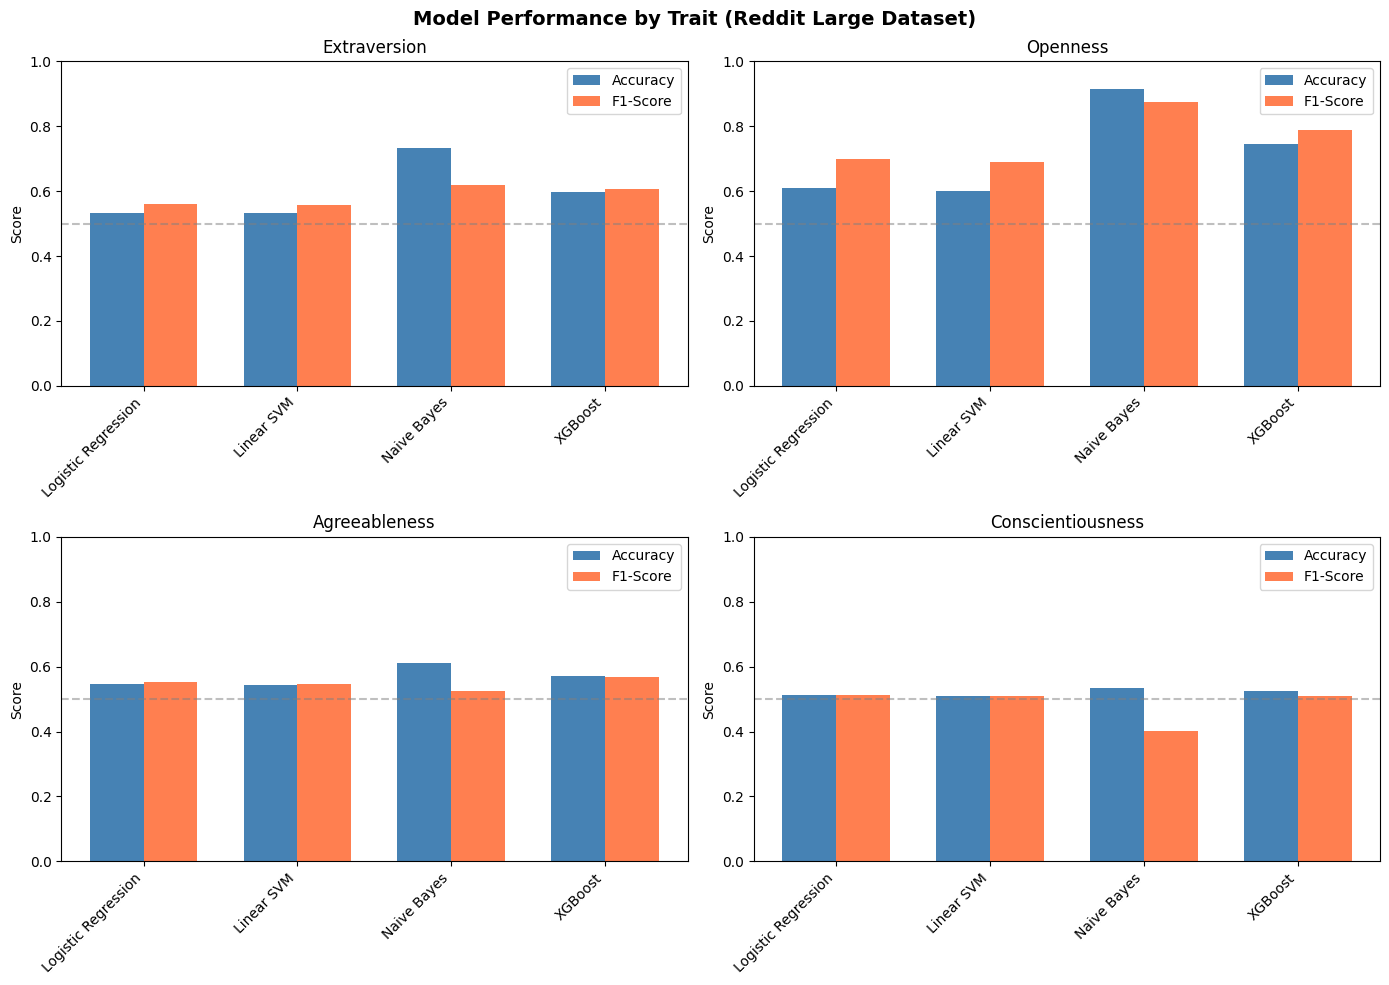

In [13]:
# ============================================
# 📊 DETAILED RESULTS PER TRAIT
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, trait in enumerate(TARGET_TRAITS):
    ax = axes[idx]
    df_result = all_results[trait]
    
    x = np.arange(len(df_result))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, df_result['Accuracy'], width, label='Accuracy', color='steelblue')
    bars2 = ax.bar(x + width/2, df_result['F1-Score'], width, label='F1-Score', color='coral')
    
    ax.set_ylabel('Score')
    ax.set_title(f'{trait}')
    ax.set_xticks(x)
    ax.set_xticklabels(df_result['Model'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.suptitle('Model Performance by Trait (Reddit Large Dataset)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

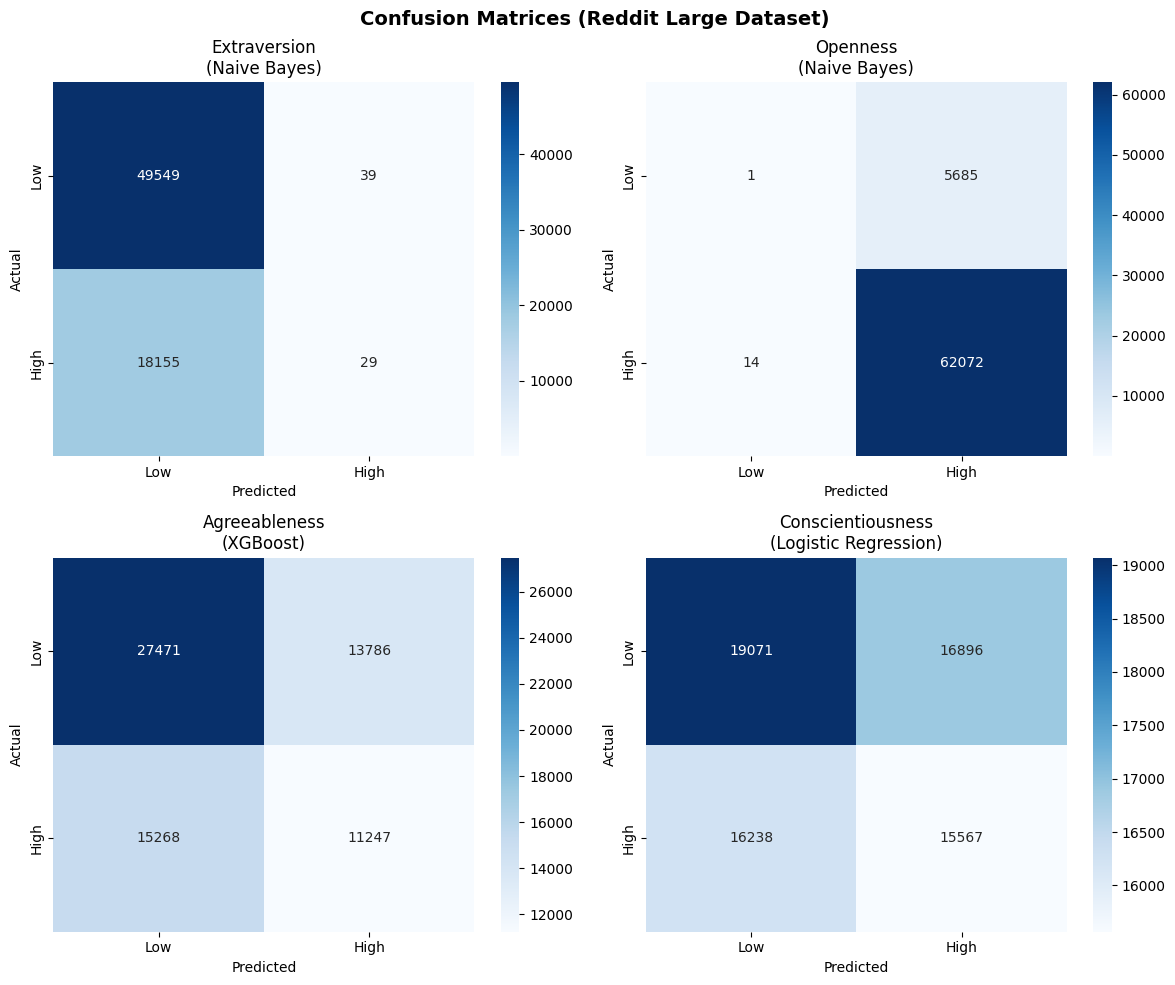

In [14]:
# ============================================
# 📋 CONFUSION MATRICES
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, trait in enumerate(TARGET_TRAITS):
    ax = axes[idx]
    best_name, best_model = best_models[trait]
    
    y_test = df_test[trait].values
    y_pred = best_model.predict(X_test_tfidf)
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    ax.set_title(f'{trait}\n({best_name})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices (Reddit Large Dataset)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# ============================================
# 📝 CLASSIFICATION REPORTS
# ============================================
print("\n" + "="*70)
print("📝 DETAILED CLASSIFICATION REPORTS")
print("="*70)

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait} ({best_models[trait][0]}):")
    print("-" * 50)
    
    best_model = best_models[trait][1]
    y_test = df_test[trait].values
    y_pred = best_model.predict(X_test_tfidf)
    
    print(classification_report(y_test, y_pred, target_names=['Low', 'High']))


📝 DETAILED CLASSIFICATION REPORTS

🎯 Extraversion (Naive Bayes):
--------------------------------------------------
              precision    recall  f1-score   support

         Low       0.73      1.00      0.84     49588
        High       0.43      0.00      0.00     18184

    accuracy                           0.73     67772
   macro avg       0.58      0.50      0.42     67772
weighted avg       0.65      0.73      0.62     67772


🎯 Openness (Naive Bayes):
--------------------------------------------------
              precision    recall  f1-score   support

         Low       0.07      0.00      0.00      5686
        High       0.92      1.00      0.96     62086

    accuracy                           0.92     67772
   macro avg       0.49      0.50      0.48     67772
weighted avg       0.84      0.92      0.88     67772


🎯 Agreeableness (XGBoost):
--------------------------------------------------
              precision    recall  f1-score   support

         Low     

---
## 5. 🔍 So sánh với Notebook gốc và No-Leakage


In [16]:
# ============================================
# 🔍 SO SÁNH VỚI CÁC PHƯƠNG PHÁP KHÁC
# ============================================

# Kết quả từ notebook gốc (cập nhật sau khi chạy)
original_results = {
    'Extraversion': {'Accuracy': 0.755043, 'F1-Score': 0.759286},
    'Openness': {'Accuracy': 0.831700, 'F1-Score': 0.835562},
    'Agreeableness': {'Accuracy': 0.778098, 'F1-Score': 0.778456},
    'Conscientiousness': {'Accuracy': 0.647839, 'F1-Score': 0.647794}
}

# Kết quả từ no-leakage notebook (copied from saved outputs)
# Updated to match the actual run results in personality_classification_no_leakage.ipynb
no_leakage_results = {
    'Extraversion': {'Accuracy': 0.738330, 'F1-Score': 0.689599},
    'Openness': {'Accuracy': 0.870356, 'F1-Score': 0.810402},
    'Agreeableness': {'Accuracy': 0.590959, 'F1-Score': 0.591458},
    'Conscientiousness': {'Accuracy': 0.540707, 'F1-Score': 0.542766}
}

print("\n" + "="*90)
print("🔍 SO SÁNH: ORIGINAL vs NO-LEAKAGE vs REDDIT LARGE")
print("="*90)
print(f"{'Trait':<20} {'Original':<12} {'No-Leakage':<12} {'Reddit':<12} {'Best':<15}")
print("-"*90)

for trait in TARGET_TRAITS:
    orig_acc = original_results[trait]['Accuracy']
    noleak_acc = no_leakage_results[trait]['Accuracy']
    reddit_acc = summary_df[summary_df['Trait'] == trait]['Accuracy'].values[0]
    
    best_method = 'Original' if orig_acc >= max(noleak_acc, reddit_acc) else \
                  ('No-Leakage' if noleak_acc >= reddit_acc else 'Reddit')
    
    print(f"{trait:<20} {orig_acc:<12.4f} {noleak_acc:<12.4f} {reddit_acc:<12.4f} {best_method:<15}")

print("-"*90)
orig_avg = np.mean([v['Accuracy'] for v in original_results.values()])
noleak_avg = np.mean([v['Accuracy'] for v in no_leakage_results.values()])
reddit_avg = summary_df['Accuracy'].mean()
print(f"{'AVERAGE':<20} {orig_avg:<12.4f} {noleak_avg:<12.4f} {reddit_avg:<12.4f}")


🔍 SO SÁNH: ORIGINAL vs NO-LEAKAGE vs REDDIT LARGE
Trait                Original     No-Leakage   Reddit       Best           
------------------------------------------------------------------------------------------
Extraversion         0.7550       0.7383       0.7315       Original       
Openness             0.8317       0.8704       0.9159       Reddit         
Agreeableness        0.7781       0.5910       0.5713       Original       
Conscientiousness    0.6478       0.5407       0.5111       Original       
------------------------------------------------------------------------------------------
AVERAGE              0.7532       0.6851       0.6825      


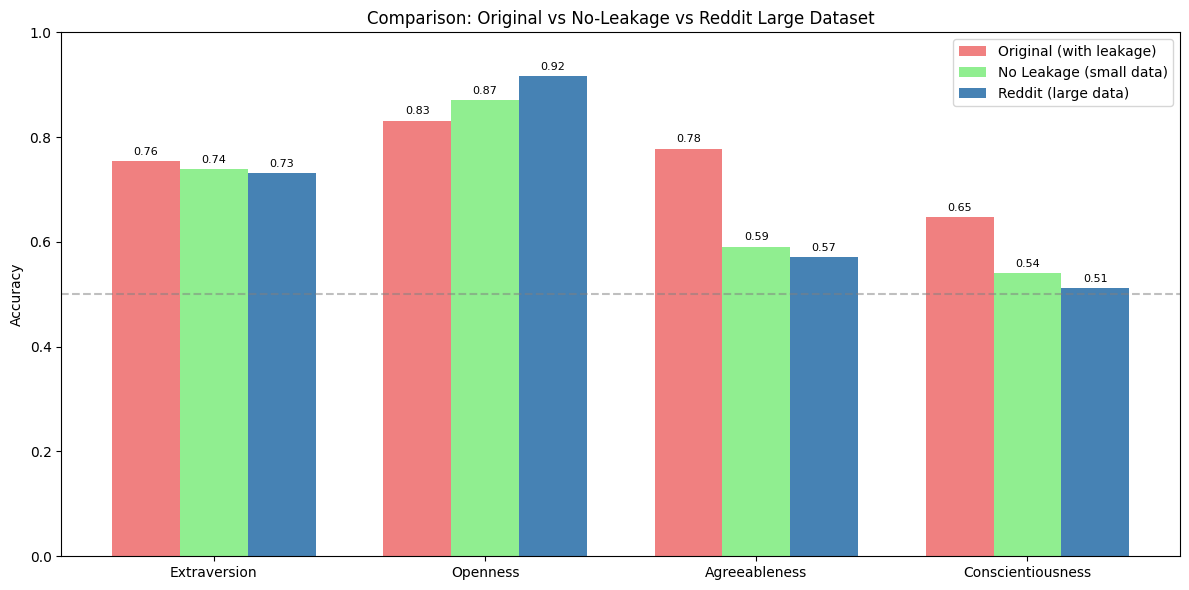

In [17]:
# ============================================
# 📊 VISUALIZATION SO SÁNH
# ============================================
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(TARGET_TRAITS))
width = 0.25

orig_accs = [original_results[t]['Accuracy'] for t in TARGET_TRAITS]
noleak_accs = [no_leakage_results[t]['Accuracy'] for t in TARGET_TRAITS]
reddit_accs = [summary_df[summary_df['Trait'] == t]['Accuracy'].values[0] for t in TARGET_TRAITS]

bars1 = ax.bar(x - width, orig_accs, width, label='Original (with leakage)', color='lightcoral')
bars2 = ax.bar(x, noleak_accs, width, label='No Leakage (small data)', color='lightgreen')
bars3 = ax.bar(x + width, reddit_accs, width, label='Reddit (large data)', color='steelblue')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison: Original vs No-Leakage vs Reddit Large Dataset')
ax.set_xticks(x)
ax.set_xticklabels(TARGET_TRAITS)
ax.legend()
ax.set_ylim(0, 1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

---
## 6. 📝 Kết luận

### 1) Thiết lập chạy thực tế (theo outputs đã lưu)
- **Reddit subset dùng để train/test**: đọc **500,000** posts ban đầu
- **Sau khi lọc author ≥ 5 posts**: **493,736** posts từ **7,028** authors
- **Sau balanced sampling (MAX_PER_TYPE = 50,000)**: **331,467** posts từ **7,015** authors
- **Split theo author (GroupShuffleSplit)** để tránh leakage

### 2) Kết quả Reddit Large (TF-IDF + ML)
- **Average (4 traits)**: **Accuracy = 0.6825**, **F1-weighted = 0.6438**

**Best model per trait (từ Results Summary):**
- Extraversion: **Naive Bayes** (Acc **0.7315**, F1 **0.6190**)
- Openness: **Naive Bayes** (Acc **0.9159**, F1 **0.8759**)
- Agreeableness: **XGBoost** (Acc **0.5713**, F1 **0.5689**)
- Conscientiousness: **Logistic Regression** (Acc **0.5111**, F1 **0.5113**)

### 3) So sánh 3 phương pháp (dựa trên bảng so sánh Accuracy đã in)
| Trait | Best method | Nhận xét ngắn |
|------|-------------|---------------|
| Extraversion | **Original** | Reddit & no-leakage thấp hơn (post-level + noise làm giảm độ ổn định) |
| Openness | **Reddit** | Reddit cải thiện rõ rệt so với cả Original và no-leakage |
| Agreeableness | **Original** | Reddit/no-leakage thấp hơn đáng kể |
| Conscientiousness | **Original** | Reddit thấp nhất trong 3 cách |

**Average Accuracy**: Original **0.7532** > No-Leakage **0.6851** ≈ Reddit **0.6825**

### 4) Kết luận cuối cùng
- **Dataset lớn hơn không tự động tốt hơn**: với Reddit (post-level, nhiều noise), kết quả **chỉ vượt trội ở Openness**, còn lại giảm.
- **Kết quả Original cao nhất nhưng không “realistic”** do nguy cơ leakage theo author-style; no-leakage và Reddit phản ánh generalization thật hơn.
- Để Reddit mạnh hơn cho các trait còn lại: cần **feature/model tốt hơn** (ví dụ n-gram/char-gram tối ưu, calibration, model ngôn ngữ/finetune) và/hoặc **chuẩn hoá theo author** (aggregate nhiều posts/author rồi split theo author).
